## Network Model of the NYC Subway Network with IBX Stations

### Constructing the Network

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline 
#pd.set_option('max_columns',None)

In [2]:
#station list, with IBX stations encoded
Stations = pd.read_csv('Stations_wIBX.csv', index_col=0, header=0)
Stations

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R
...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX
504,74 St,X14,Q,40.733015,-73.887789,IBX
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX


In [3]:
#filter out Staten Island, as its rail network is unconnected with the rest of the network
Stations = Stations.loc[Stations['boro'] != 'SI']

In [4]:
#Split the lines into multiple columns
Stations = Stations.join(Stations['lines'].str.split(' ', expand=True)).rename({0:'line_1',1:'line_2',2:'line_3',3:'line_4'}, axis=1)
Stations

,name,id,boro,lat,long,lines,line_1,line_2,line_3,line_4
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,G,None,None,None
1,21 St,G24,Q,40.744065,-73.949724,G,G,None,None,None
2,Court Sq,G22,Q,40.746554,-73.943832,G,G,None,None,None
3,36 St,G20,Q,40.752039,-73.928781,M R,M,R,None,None
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,E,M,R,None
...,...,...,...,...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX,IBX,None,None,None
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX,IBX,None,None,None
504,74 St,X14,Q,40.733015,-73.887789,IBX,IBX,None,None,None
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX,IBX,None,None,None


In [5]:
#For stations with more than 1 line, unpivot to create new rows.
stli = pd.wide_to_long(Stations, stubnames='line_',i='id',j='station_line').sort_index(level=0)
stli.dropna(inplace=True)
stli.reset_index(inplace=True)
stli.rename({'id':'station_id'},axis=1,inplace=True)
stli

,station_id,station_line,long,lines,boro,name,lat,line_
0,101,1,-73.898583,1,Bx,Van Cortlandt Park - 242 St,40.889248,1
1,103,1,-73.900870,1,Bx,238 St,40.884667,1
2,104,1,-73.904834,1,Bx,231 St,40.878856,1
3,106,1,-73.909831,1,M,Marble Hill - 225 St,40.874561,1
4,107,1,-73.915279,1,M,215 St,40.869444,1
...,...,...,...,...,...,...,...,...
760,X16,1,-73.894401,IBX,Q,Jackson Hts,40.746530,IBX
761,X5,1,-73.947985,IBX,Bk,Brooklyn College,40.630902,IBX
762,X6,1,-73.928442,IBX,Bk,Farragut Rd - Utica Av,40.637348,IBX
763,X7,1,-73.919353,IBX,Bk,Ralph Av,40.643589,IBX


In [6]:
#each station-line has 2 platforms for trains going in both directions, so we can duplicate the table
pfs = pd.concat([stli]*2)
#create a new columns to distinguish north and south-bound trains, add South designation to half of the rows
pfs['dir'] = 'N'
pfs.iloc[:stli.shape[0],8] = 'S'
pfs

,station_id,station_line,long,lines,boro,name,lat,line_,dir
0,101,1,-73.898583,1,Bx,Van Cortlandt Park - 242 St,40.889248,1,S
1,103,1,-73.900870,1,Bx,238 St,40.884667,1,S
2,104,1,-73.904834,1,Bx,231 St,40.878856,1,S
3,106,1,-73.909831,1,M,Marble Hill - 225 St,40.874561,1,S
4,107,1,-73.915279,1,M,215 St,40.869444,1,S
...,...,...,...,...,...,...,...,...,...
760,X16,1,-73.894401,IBX,Q,Jackson Hts,40.746530,IBX,N
761,X5,1,-73.947985,IBX,Bk,Brooklyn College,40.630902,IBX,N
762,X6,1,-73.928442,IBX,Bk,Farragut Rd - Utica Av,40.637348,IBX,N
763,X7,1,-73.919353,IBX,Bk,Ralph Av,40.643589,IBX,N


In [7]:
#create platform_id field based on station_id + line + dir
pfs['pf_id'] = pfs['station_id'] + '-' + pfs['line_'] + '-' + pfs['dir']
pfs

,station_id,station_line,long,lines,boro,name,lat,line_,dir,pf_id
0,101,1,-73.898583,1,Bx,Van Cortlandt Park - 242 St,40.889248,1,S,101-1-S
1,103,1,-73.900870,1,Bx,238 St,40.884667,1,S,103-1-S
2,104,1,-73.904834,1,Bx,231 St,40.878856,1,S,104-1-S
3,106,1,-73.909831,1,M,Marble Hill - 225 St,40.874561,1,S,106-1-S
4,107,1,-73.915279,1,M,215 St,40.869444,1,S,107-1-S
...,...,...,...,...,...,...,...,...,...,...
760,X16,1,-73.894401,IBX,Q,Jackson Hts,40.746530,IBX,N,X16-IBX-N
761,X5,1,-73.947985,IBX,Bk,Brooklyn College,40.630902,IBX,N,X5-IBX-N
762,X6,1,-73.928442,IBX,Bk,Farragut Rd - Utica Av,40.637348,IBX,N,X6-IBX-N
763,X7,1,-73.919353,IBX,Bk,Ralph Av,40.643589,IBX,N,X7-IBX-N


In [8]:
#let's change the lat-long slightly for the platforms so they aren't totally on top of each other. this is not meant to be geographically accurate!
#offset the 1st platform from the station by .0006 degrees lat, which is about 200 feet north
pfs.loc[pfs.station_line ==1,'lat'] = pfs.loc[pfs.station_line ==1,'lat'] + .0006
pfs.loc[pfs.station_line ==2,'long'] = pfs.loc[pfs.station_line ==2,'long'] + .0006 #offset to east
pfs.loc[pfs.station_line ==3,'lat'] = pfs.loc[pfs.station_line ==3,'lat'] - .0006  #offset to south
pfs.loc[pfs.station_line ==4,'long'] = pfs.loc[pfs.station_line ==4,'long'] - .0006 #offset to west

#and let's offset the north platforms from the south by adding .0001 degrees lat or ~35 feet north
pfs.loc[pfs.dir =='N','lat'] = pfs.loc[pfs.dir =='N','lat'] + .0006


In [9]:
#finally, let's concatenate the stations to the platforms
Stations.rename({'id':'station_id','lines':'line_'},axis=1,inplace=True)
Stations.drop(['line_1','line_2','line_3','line_4'],axis = 1,inplace=True)
Stations[['pf_id','dir','station_line']] = 'station'
nodes = pd.concat([pfs,Stations])

In [10]:
nodes['node_id'] = np.where(nodes['pf_id'] != 'station',nodes['pf_id'],nodes['station_id'])
nodes.reset_index(inplace=True,drop=True)
nodes

,station_id,station_line,long,lines,boro,name,lat,line_,dir,pf_id,node_id
0,101,1,-73.898583,1,Bx,Van Cortlandt Park - 242 St,40.889848,1,S,101-1-S,101-1-S
1,103,1,-73.900870,1,Bx,238 St,40.885267,1,S,103-1-S,103-1-S
2,104,1,-73.904834,1,Bx,231 St,40.879456,1,S,104-1-S,104-1-S
3,106,1,-73.909831,1,M,Marble Hill - 225 St,40.875161,1,S,106-1-S,106-1-S
4,107,1,-73.915279,1,M,215 St,40.870044,1,S,107-1-S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...
2009,X8,station,-73.908889,NaN,Bk,Rockaway Pkwy,40.651228,IBX,station,station,X8
2010,X12,station,-73.894421,NaN,Q,Myrtle Av,40.700453,IBX,station,station,X12
2011,X14,station,-73.887789,NaN,Q,74 St,40.733015,IBX,station,station,X14
2012,X15,station,-73.890111,NaN,Q,Queens Blvd,40.738486,IBX,station,station,X15


In [11]:
nodes.iloc[100:140]

,station_id,station_line,long,lines,boro,name,lat,line_,dir,pf_id,node_id
100,229,2,-74.005971,2 3,M,Fulton St,40.709416,3,S,229-3-S,229-3-S
101,230,1,-74.009100,2 3,M,Wall St,40.707421,2,S,230-2-S,230-2-S
102,230,2,-74.008500,2 3,M,Wall St,40.706821,3,S,230-3-S,230-3-S
103,231,1,-73.993086,2 3,Bk,Clark St,40.698066,2,S,231-2-S,231-2-S
104,231,2,-73.992486,2 3,Bk,Clark St,40.697466,3,S,231-3-S,231-3-S
105,232,1,-73.989998,2 3,Bk,Borough Hall,40.693819,2,S,232-2-S,232-2-S
106,232,2,-73.989398,2 3,Bk,Borough Hall,40.693219,3,S,232-3-S,232-3-S
107,233,1,-73.985065,2 3,Bk,Hoyt St,40.691145,2,S,233-2-S,233-2-S
108,233,2,-73.984465,2 3,Bk,Hoyt St,40.690545,3,S,233-3-S,233-3-S
109,234,1,-73.980492,2 3 4 5,Bk,Nevins St,40.688846,2,S,234-2-S,234-2-S


In [12]:
#next step is edges. the edge list actually shows multiple edges for each line and direction. for example, station 230 (Wall Street) 
# and station 231 (Clark Street) are already connected by 4 edges: the 2 and 3 trains, northbound and southbound. However, because the stations
# are represented as single nodes, these 4 edges are indistinguishable from one another, and networkx only uses 1 of them anyway.

#so for each of these existing edges, we need to reset the origin and destination based on the platform_id. In the example above, we need to
# end up with the following edges:
# 230-2-S --> 231-2-S
# 230-3-S --> 231-3-S
# 231-2-N --> 230-2-N
# 231-3-N --> 230-3-N

#actually, we don't need this to be a directed graph, so don't worry if northbound edges are going south.
# But it is important that only edges with the same line and direction are connected. So we can't have a southbound train going to a northbound
# platform, and we can't have a 2 train going to a 3 platform (even though in actuality they do share a platfom)

#So basically, for each unique origin and destination in the edge list, we need to look up the lines that are serving both of those stations.
# If the stations have line(s) in common, we draw an edge between the corresponding platforms in both directions

# I think the easiest way to do this in practice is to add a bunch of columns to the edge list, for each of the ~31 subway lines
# If both the origin and destination of the edge contain the same line, mark that as a 1, otherwise if one/both doesn't have that line mark 0

#After all of this, don't forget to add edges between the stations and platforms!


In [13]:
#connection list, with IBX connections encoded
Links = pd.read_csv('Links_wIBX.csv', index_col=0, header=0)
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [14]:
#the repeated edges are of no use to us, so let's get unique edges.
uLinks = Links.drop_duplicates().reset_index()
uLinks.drop('index',axis=1,inplace=True)
uLinks.shape

(1246, 2)

In [15]:
#get the links for the Prospect Park Shuttle
S_links = uLinks.loc[(uLinks['origin'].isin(['S01', 'S03', 'S04'])) | \
    (uLinks['dest'].isin(['S01', 'S03', 'S04']))]

S_links

,origin,dest
154,A45,S01
237,239,S04
1077,D26,S04
1107,S01,S03
1108,S01,A45
1109,S03,S01
1110,S03,S04
1111,S04,S03
1112,S04,239
1113,S04,D26


In [16]:
#drop links from Staten Island, concatenate Shuttle links back in (since they get dropped here)
uLinks = uLinks.loc[(~uLinks['origin'].str.startswith('S')) | (~uLinks['dest'].str.startswith('S'))]

uLinks = pd.concat([uLinks, S_links], ignore_index=True)
uLinks

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24
...,...,...
1203,S03,S01
1204,S03,S04
1205,S04,S03
1206,S04,239


In [17]:
#Also, we don't need a directed graph because we will incorporate that logic into the platforms, i.e. only northbound platforms can have an edge, but the direction of that edge
#isn't important. If the northbound edges are actually going south geographically, it doesn't make a difference. So let's remove duplicate edges that are A-->B and B-->A
uuLinks = uLinks[~pd.DataFrame(np.sort(uLinks[['origin','dest']].values,1)).duplicated()].sort_values('origin')
uuLinks.reset_index(inplace=True)
uuLinks

,index,origin,dest
0,126,103,104
1,125,103,101
2,129,106,104
3,128,106,107
4,121,108,109
...,...,...,...
614,1182,X16,G14
615,1170,X5,X6
616,1171,X6,X7
617,1172,X7,X8


In [18]:
d = pd.DataFrame(np.zeros((uuLinks.shape[0], pfs.line_.nunique())))
d.columns = pfs.line_.unique()
uuLinks = pd.concat([uuLinks,d],axis=1)
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,...,G,Q,M,IBX,N,J,Z,R,L,W
0,126,103,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,125,103,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,129,106,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128,106,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121,108,109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,1182,X16,G14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615,1170,X5,X6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
616,1171,X6,X7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
617,1172,X7,X8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
i = 0
for o, d in zip(uuLinks.origin, uuLinks.dest):
    o_lines = Stations.loc[Stations['station_id'] == o,'line_'].str.strip().str.split(' ').values[0]
    d_lines = Stations.loc[Stations['station_id'] == d,'line_'].str.strip().str.split(' ').values[0]
    common = [value for value in o_lines if value in d_lines]
    for lc in common:
        uuLinks.loc[uuLinks.index[i],lc] =1
    i +=1

In [20]:
Stations.loc[Stations['station_id'] == '104','line_'].str.strip().str.split(' ').values[0]

['1']

In [21]:
#I got the output I wanted, but it's tricky because some stations are actually represented as multiple nodes, e.g. Union Sq vs Union Sq - 14 St.
# There are actually quite a few of these (146 edges). I will draw edges between the stations themselves, not the platforms. So basically I can leave them as-is.
# everything else is a platform-platform edge (until we draw station-platform edges)

uuLinks['total_edges'] = 0
for i in uuLinks.index:
    uuLinks.loc[i, 'total_edges'] = uuLinks.loc[i, '1':'total_edges'].sum()

pfs_edges = uuLinks[uuLinks['total_edges'] > 0]
ss_edges = uuLinks[uuLinks['total_edges'] == 0]


In [22]:
pfs_edges.head()

,index,origin,dest,1,2,3,5,4,6,7,...,Q,M,IBX,N,J,Z,R,L,W,total_edges
0,126,103,104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,125,103,101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,129,106,104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,128,106,107,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,121,108,109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [23]:
#each platform edge needs to be multiplied by the total_edges. Let's use wide to long, then filter out all of the 0 edges
pfs_edges_tr = pfs_edges.drop(['total_edges','index'],axis=1).melt(id_vars=['origin','dest'])
pfs_edges_tr = pfs_edges_tr[pfs_edges_tr['value'] >0]
pfs_edges_tr = pfs_edges_tr.rename({'variable':'line'},axis=1).drop('value',axis=1)
pfs_edges_tr

,origin,dest,line
0,103,104,1
1,103,101,1
2,106,104,1
3,106,107,1
4,108,109,1
...,...,...,...
12971,R23,R22,W
12972,R24,R23,W
12973,R25,R24,W
12974,R26,R25,W


In [24]:
#rename the origin and destination based on the line and direction.
pfs_edges_tr['origin_stli'] = pfs_edges_tr['origin'] + '-' + pfs_edges_tr['line']
pfs_edges_tr['dest_stli'] = pfs_edges_tr['dest'] + '-' + pfs_edges_tr['line']

#double the dataframe for northbound and southbound platforms
pfs_edges_tr = pd.concat([pfs_edges_tr]*2)
pfs_edges_tr['dir'] = 'N'
pfs_edges_tr.iloc[:int(pfs_edges_tr.shape[0]/2), 5] = 'S'
pfs_edges_tr

,origin,dest,line,origin_stli,dest_stli,dir
0,103,104,1,103-1,104-1,S
1,103,101,1,103-1,101-1,S
2,106,104,1,106-1,104-1,S
3,106,107,1,106-1,107-1,S
4,108,109,1,108-1,109-1,S
...,...,...,...,...,...,...
12971,R23,R22,W,R23-W,R22-W,N
12972,R24,R23,W,R24-W,R23-W,N
12973,R25,R24,W,R25-W,R24-W,N
12974,R26,R25,W,R26-W,R25-W,N


In [25]:
pfs_edges_tr['origin'] = pfs_edges_tr['origin_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr['dest'] = pfs_edges_tr['dest_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr.drop(['origin_stli','dest_stli','dir'],axis=1,inplace=True)
pfs_edges_tr.reset_index(inplace=True, drop=True)
pfs_edges_tr

,origin,dest,line
0,103-1-S,104-1-S,1
1,103-1-S,101-1-S,1
2,106-1-S,104-1-S,1
3,106-1-S,107-1-S,1
4,108-1-S,109-1-S,1
...,...,...,...
1597,R23-W-N,R22-W-N,W
1598,R24-W-N,R23-W-N,W
1599,R25-W-N,R24-W-N,W
1600,R26-W-N,R25-W-N,W


In [26]:
#we now have all station-to-station edges and platform-to-platform edges. Now let's make a final set of edges between the station and its platforms.
#We can just use the platforms dataframe to get the platform ID and the station ID the platform belongs to
stpf_edges = pfs[['station_id','pf_id','line_']]
stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)
stpf_edges

C:\Users\Rohan\AppData\Local\Temp\ipykernel_9340\2067928534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)


,origin,dest,line
0,101,101-1-S,1
1,103,103-1-S,1
2,104,104-1-S,1
3,106,106-1-S,1
4,107,107-1-S,1
...,...,...,...
760,X16,X16-IBX-N,IBX
761,X5,X5-IBX-N,IBX
762,X6,X6-IBX-N,IBX
763,X7,X7-IBX-N,IBX


In [27]:
#remove unnecessary columns from station to station edges
ss_edges = ss_edges[['origin','dest']]
ss_edges['line'] = 'station'
ss_edges.reset_index(inplace=True, drop=True)
ss_edges

,origin,dest,line
0,125,A24,station
1,127,A27,station
2,127,725,station
3,127,R16,station
4,132,D19,station
...,...,...,...
72,R16,725,station
73,R31,D24,station
74,X1,R41,station
75,X16,710,station


In [28]:
#finally! let's concat the station-to-station, platform-to-platform, and station-to-platform edges
edges = pd.concat([ss_edges.reset_index(drop=True), stpf_edges.reset_index(drop=True), pfs_edges_tr.reset_index(drop=True)],axis=0)
edges.reset_index(inplace=True,drop=True)
edges

,origin,dest,line
0,125,A24,station
1,127,A27,station
2,127,725,station
3,127,R16,station
4,132,D19,station
...,...,...,...
3204,R23-W-N,R22-W-N,W
3205,R24-W-N,R23-W-N,W
3206,R25-W-N,R24-W-N,W
3207,R26-W-N,R25-W-N,W


In [29]:
#create a dictionary of subway stations by name and location
StPos={Stations.station_id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.station_id[c]:Stations.name[c] for c in Stations.index}

In [30]:
nodes.head()

,station_id,station_line,long,lines,boro,name,lat,line_,dir,pf_id,node_id
0,101,1,-73.898583,1,Bx,Van Cortlandt Park - 242 St,40.889848,1,S,101-1-S,101-1-S
1,103,1,-73.900870,1,Bx,238 St,40.885267,1,S,103-1-S,103-1-S
2,104,1,-73.904834,1,Bx,231 St,40.879456,1,S,104-1-S,104-1-S
3,106,1,-73.909831,1,M,Marble Hill - 225 St,40.875161,1,S,106-1-S,106-1-S
4,107,1,-73.915279,1,M,215 St,40.870044,1,S,107-1-S,107-1-S


In [31]:
#create a dictionary of subway stations by name and location
nodePos={nodes.node_id[c]:(nodes.long[c],nodes.lat[c]) for c in nodes.index}
nodeName={nodes.node_id[c]:nodes.name[c] for c in nodes.index}

In [32]:
#this is the graph with platforms and lines
uuNYCSubway=nx.Graph()
for i in edges.index:
   uuNYCSubway.add_edge(edges.origin[i],edges.dest[i])   

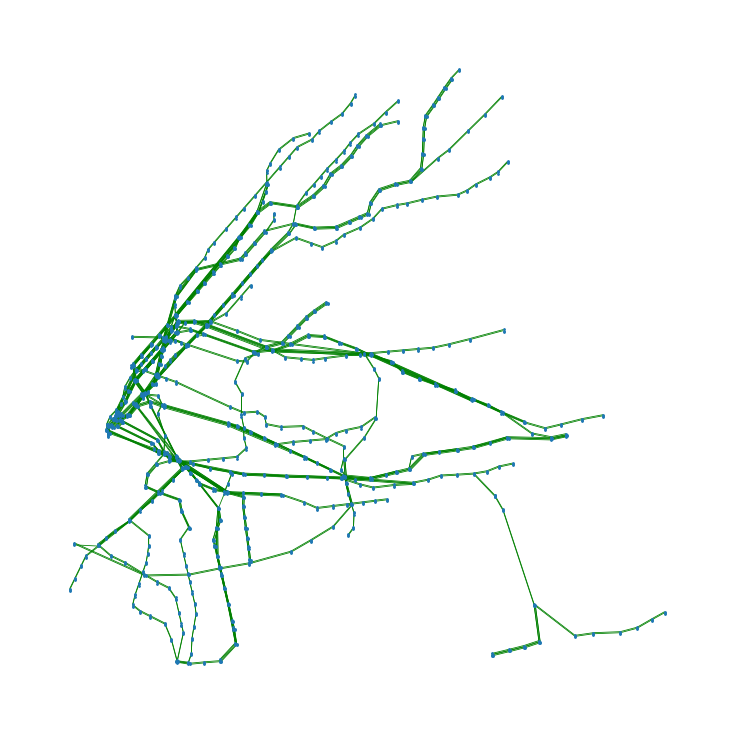

In [33]:
#visualize the subway newtork
plt.figure(figsize = (10,10))
nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=0.8,edge_color='green')

### Populating the Edge Weights and Calculating Centrality

##### Station to Station Edge Weights

In [34]:
#First will populate the edge weights for station to station edges. These weights will signify the time it takes to walk between
#different train divisions in a large train stations (e.g. walking betwen the 7 platform and E F M R platforms at Jackson Hts)

#get tuples of all stations to station edges
ss_edge_tup = [tuple(x) for x in ss_edges[['origin','dest']].to_numpy()]

In [35]:
#create empty dictionary, and populate it with the station to station tuples as the key, and 3 as the value (indicating a 3 minute
#time cost to transfer between stations on these types edges)
ss_edge_dict = {}

for tup in ss_edge_tup:
    ss_edge_dict[tup] = 3

#set edge attributes for station to station edges using populated dictionary
nx.set_edge_attributes(uuNYCSubway, ss_edge_dict, name = 'travel_time')

##### Platform to Platform Edge Weights

In [ ]:
#next is platform to platform edge weights, which signify the travel times while the train is actually moving. We first need
# train speed data, which will be divided by the geographic distance to get travel time. Train speed data will
#be gathered from the Dec. 2021 GTFS update for the NYC Subway. A package specfically for dealing with GTFS data will be imported
#to get the average train speeds for every train line. 
import gtfs_functions as gtfs

routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(r'C:\Users\Rohan\Documents\NYU\ADS\ADS Final Project\nycsubway_gtfs.zip')

segments_gdf = gtfs.cut_gtfs(stop_times, stops, shapes)

speeds = gtfs.speeds_from_gtfs(routes, stop_times, segments_gdf, cutoffs=[0,6,9,15,20,24])

In [37]:
#calculate average speed for every line, dropping ones that aren't modeled by our network
speeds_by_line = speeds.groupby(['route_id', 'route_name'])['speed_mph'].mean().drop(['ALL_LINES', '6X', '7X', 'FS']); speeds_by_line

route_id  route_name                       
1         1 Broadway - 7 Avenue Local          16.119494
2         2 7 Avenue Express                   14.962729
3         3 7 Avenue Express                   15.273299
4         4 Lexington Avenue Express           16.305569
5         5 Lexington Avenue Express           15.775591
6         6 Lexington Avenue Local             15.487351
7         7 Flushing Local                     16.885795
A         A 8 Avenue Express                   17.490534
B         B 6 Avenue Express                   18.082812
C         C 8 Avenue Local                     17.106892
D         D 6 Avenue Express                   16.191758
E         E 8 Avenue Local                     17.297475
F         F Queens Blvd Express/ 6 Av Local    16.875401
FX        FX Brooklyn F Express                16.932360
GS        S 42 St Shuttle                      17.398388
H         S Rockaway Park Shuttle              17.990244
J         J Nassau St Local                 

In [38]:
#avg speed for the IBX is projected to be 18.67 mph (14 miles track length, with 45 mins estimated run time)
speeds_by_line['IBX'] = 18.67
speeds_by_line['W'] = speeds_by_line['N'].values[0]

speeds_by_line = speeds_by_line.reset_index()[['route_id', 'speed_mph']]

In [39]:
#rename route_ids for joining to the edge list
speeds_by_line.loc[speeds_by_line['route_id'] == 'FX', 'route_id'] = 'Q'
speeds_by_line.loc[speeds_by_line['route_id'] == 'H', 'route_id'] = 'S'
speeds_by_line.loc[speeds_by_line['route_id'] == 'GS', 'route_id'] = 'G'

In [56]:
#speeds_by_line.to_csv('avg_speeds_by_line.csv')

In [40]:
#merge on the list of platform edges
pfs_edges_speeds = pfs_edges_tr.merge(speeds_by_line, left_on = 'line', right_on = 'route_id'); pfs_edges_speeds

,origin,dest,line,route_id,speed_mph
0,103-1-S,104-1-S,1,1,16.119494
1,103-1-S,101-1-S,1,1,16.119494
2,106-1-S,104-1-S,1,1,16.119494
3,106-1-S,107-1-S,1,1,16.119494
4,108-1-S,109-1-S,1,1,16.119494
...,...,...,...,...,...
1597,R23-W-N,R22-W-N,W,W,15.744100
1598,R24-W-N,R23-W-N,W,W,15.744100
1599,R25-W-N,R24-W-N,W,W,15.744100
1600,R26-W-N,R25-W-N,W,W,15.744100


In [41]:
#import package to calculate geodesic distance between lat/long pairs
from geopy.distance import geodesic

#get list of tuples for platform to platform edges
pp_edge_tup = [tuple(x) for x in pfs_edges_speeds[['origin','dest']].to_numpy()]

#create empty dict
pp_edge_dict = {}

#for every tuple in the list
for tup in pp_edge_tup:
    lon1, lat1 = nodePos.get(tup[0]) #get the node positions
    lon2, lat2 = nodePos.get(tup[1])
    dist = geodesic((lat1, lon1), (lat2, lon2)).miles  #calc distance in miles
    spd = pfs_edges_speeds.loc[pfs_edges_speeds['origin'] == tup[0], 'speed_mph'].values[0] #get the speed of the line (mph)
    pp_edge_dict[tup] = (dist/spd)*60 #calc time in minutes

In [42]:
#set the edge attributes using the populated dictionary
nx.set_edge_attributes(uuNYCSubway, pp_edge_dict, name = 'travel_time')

##### Station to Platform Edge Weights

In [43]:
#next is station to platform edges, which signify the train frequencies or headways (i.e. how long a person has to wait at 
# a platform for the next train to come). Headways vary wildly depending on if its peak or off-peak service hours. At peak hours,
#average headways are 2-5 minutes. At off-peak hours, average headways are 10-20 minutes. To be conservative, we will
#set the peak headways to be 5 minutes, and the off-peak headways to be 15 minutes 

#first need to make a copy of the existing graph, and set one to be the peak hours graph, and one to be the off-peak graph
uuNYCSubway_peak = uuNYCSubway.copy()

uuNYCSubway_offpeak = uuNYCSubway.copy()

uuNYCSubway_peak.graph['time'] = 'peak'

uuNYCSubway_offpeak.graph['time'] = 'offpeak'

In [44]:
#get list of tuples for every station to platform edge
sp_edge_tup = [tuple(x) for x in stpf_edges[['origin','dest']].to_numpy()]

sp_edge_dict_peak = {}
sp_edge_dict_offpeak = {}

#populate the peak/offpeak dictionaries with their respective headways, in minutes
for tup in sp_edge_tup:
    sp_edge_dict_peak[tup] = 5
    sp_edge_dict_offpeak[tup] = 15

In [45]:
#set the edge attributes for the two separate graphs
nx.set_edge_attributes(uuNYCSubway_peak, sp_edge_dict_peak, name = 'travel_time')
nx.set_edge_attributes(uuNYCSubway_offpeak, sp_edge_dict_offpeak, name = 'travel_time')

In [46]:
nx.get_edge_attributes(uuNYCSubway_peak, name = 'travel_time')

{('125', 'A24'): 3,
 ('125', '125-1-S'): 5,
 ('125', '125-1-N'): 5,
 ('A24', 'A24-A-S'): 5,
 ('A24', 'A24-B-S'): 5,
 ('A24', 'A24-C-S'): 5,
 ('A24', 'A24-D-S'): 5,
 ('A24', 'A24-A-N'): 5,
 ('A24', 'A24-B-N'): 5,
 ('A24', 'A24-C-N'): 5,
 ('A24', 'A24-D-N'): 5,
 ('127', 'A27'): 3,
 ('127', '725'): 3,
 ('127', 'R16'): 3,
 ('127', '902'): 3,
 ('127', '127-1-S'): 5,
 ('127', '127-2-S'): 5,
 ('127', '127-3-S'): 5,
 ('127', '127-1-N'): 5,
 ('127', '127-2-N'): 5,
 ('127', '127-3-N'): 5,
 ('A27', '902'): 3,
 ('A27', 'R16'): 3,
 ('A27', '725'): 3,
 ('A27', 'A27-A-S'): 5,
 ('A27', 'A27-C-S'): 5,
 ('A27', 'A27-E-S'): 5,
 ('A27', 'A27-A-N'): 5,
 ('A27', 'A27-C-N'): 5,
 ('A27', 'A27-E-N'): 5,
 ('725', '902'): 3,
 ('725', 'R16'): 3,
 ('725', '725-7-S'): 5,
 ('725', '725-7-N'): 5,
 ('R16', '902'): 3,
 ('R16', 'R16-N-S'): 5,
 ('R16', 'R16-Q-S'): 5,
 ('R16', 'R16-R-S'): 5,
 ('R16', 'R16-W-S'): 5,
 ('R16', 'R16-N-N'): 5,
 ('R16', 'R16-Q-N'): 5,
 ('R16', 'R16-R-N'): 5,
 ('R16', 'R16-W-N'): 5,
 ('132', 'D1

##### Centrality Scores

In [ ]:
#peak closeness centrality
peak_centrality_scores = pd.DataFrame.from_dict(nx.closeness_centrality(uuNYCSubway_peak, distance='travel_time'), orient = 'index')

In [69]:
peak_centrality_scores = peak_centrality_scores.rename({0:'closeness_centrality'}, axis = 'columns')
peak_centrality_scores

,closeness_centrality
125,0.023370
A24,0.024333
127,0.026232
A27,0.026540
725,0.026013
...,...
X16-IBX-N,0.019714
X5-IBX-N,0.018997
X6-IBX-N,0.018501
X7-IBX-N,0.018323


In [73]:
peak_centrality_scores.to_csv('ctrl_scrs_sta_IBX_peak.csv')

In [71]:
offpeak_centrality_scores = pd.DataFrame.from_dict(nx.closeness_centrality(uuNYCSubway_offpeak, distance='travel_time'), orient = 'index')

In [72]:
offpeak_centrality_scores = offpeak_centrality_scores.rename({0:'closeness_centrality'}, axis = 'columns')
offpeak_centrality_scores

,closeness_centrality
125,0.014168
A24,0.014528
127,0.016678
A27,0.016802
725,0.016589
...,...
X16-IBX-N,0.011929
X5-IBX-N,0.012083
X6-IBX-N,0.011927
X7-IBX-N,0.011862


In [74]:
offpeak_centrality_scores.to_csv('ctrl_scrs_sta_IBX_offpeak.csv')

In [76]:
import seaborn as sns

sns.



### Diagnostics and Troubleshooting

In [53]:
#Test: Shortest path between New Utrecht Sta. (N04) and Jackson Hts - Roosevelt Ave (G14)

#@peak-hours
peak1 = nx.shortest_path(uuNYCSubway_peak, 'N04', 'G14', weight='travel_time')
print(peak1)

#@offpeak-hours
offpeak1 = nx.shortest_path(uuNYCSubway_peak, 'N04', 'G14', weight='travel_time')
print(offpeak1)

['N04', 'N04-IBX-N', 'F31-IBX-N', 'D32-IBX-N', 'X5-IBX-N', 'X6-IBX-N', 'X7-IBX-N', 'X8-IBX-N', 'L26-IBX-N', 'L24-IBX-N', 'L20-IBX-N', 'X12-IBX-N', 'M01-IBX-N', 'X14-IBX-N', 'X15-IBX-N', 'X16-IBX-N', 'X16', 'G14']
['N04', 'N04-IBX-N', 'F31-IBX-N', 'D32-IBX-N', 'X5-IBX-N', 'X6-IBX-N', 'X7-IBX-N', 'X8-IBX-N', 'L26-IBX-N', 'L24-IBX-N', 'L20-IBX-N', 'X12-IBX-N', 'M01-IBX-N', 'X14-IBX-N', 'X15-IBX-N', 'X16-IBX-N', 'X16', 'G14']


In [57]:
print('Travel time, peak hours: ', round(nx.shortest_path_length(uuNYCSubway_peak, 'N04', 'G14', weight='travel_time'), 2))
print('Travel time, offpeak hours: ', round(nx.shortest_path_length(uuNYCSubway_offpeak, 'N04', 'G14', weight='travel_time'),2))

Travel time, peak hours:  51.73
Travel time, offpeak hours:  71.73


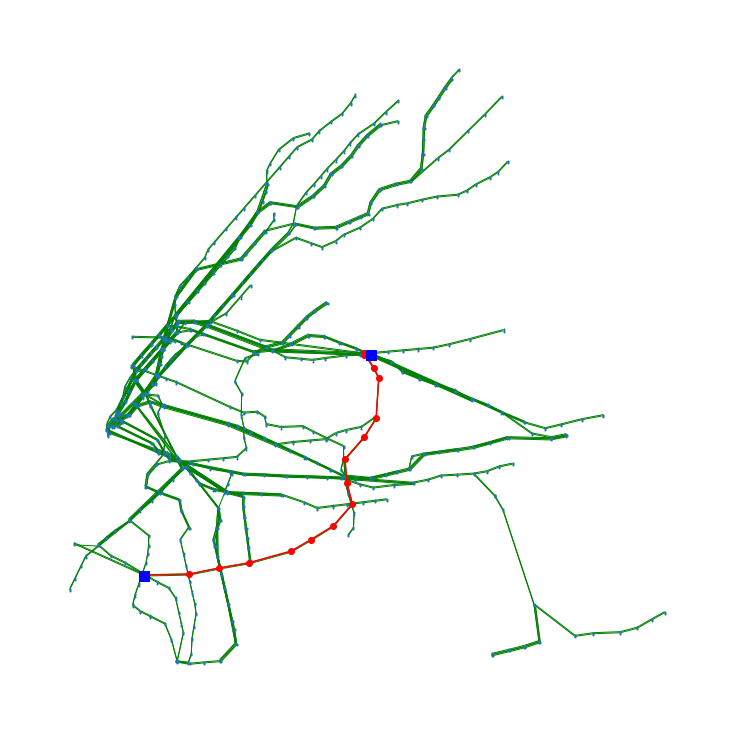

In [55]:
visualize_path(peak1)

In [28]:
#check that each line is a single component. The S line includes the rockaway shuttle, franklin shuttle, and 42nd st shuttle
for l in nodes.loc[nodes['pf_id'] != 'station','line_'].unique():
    lgr=nx.Graph()
    for i in edges.index:
        if edges.loc[i,'line'] == l:
            lgr.add_edge(edges.origin[i],edges.dest[i])  
    cc = nx.number_connected_components(lgr)
    print(f'{l} line has {cc} components')

1 line has 1 components
2 line has 1 components
3 line has 1 components
5 line has 1 components
4 line has 1 components
6 line has 1 components
7 line has 1 components
S line has 3 components
A line has 1 components
C line has 1 components
B line has 1 components
D line has 1 components
E line has 1 components
F line has 1 components
G line has 1 components
Q line has 1 components
M line has 1 components
IBX line has 1 components
N line has 1 components
J line has 1 components
Z line has 1 components
R line has 1 components
L line has 1 components
W line has 1 components
SIR line has 1 components


In [ ]:
#use this function to check that none of the lines has gaps/missing edges
lgr=nx.Graph()
for i in edges.index:
    if edges.loc[i,'line'] == 'Z':
        lgr.add_edge(edges.origin[i],edges.dest[i])  

for c in nx.connected_components(lgr):
    print(c)

plt.figure(figsize = (30,30))
nx.draw(lgr,pos=nodePos,with_labels=True,arrows=False,node_size=3,width=0.8,edge_color='green')

#### Task 1a. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707)

In [30]:
path1=nx.shortest_path(uuNYCSubway,'A41','707')
path2=nx.shortest_path(uuNYCSubway,'A40','F16')

In [31]:
path1

['A41',
 'A41-F-S',
 'F18-F-S',
 'F16-F-S',
 'F15-F-S',
 'F14-F-S',
 'D21-F-S',
 'D20-F-S',
 'D17-F-S',
 'D16-F-S',
 'D15-F-S',
 'B10-F-S',
 'B08-F-S',
 'B06-F-S',
 'B04-F-S',
 'G14-F-S',
 'G14',
 '710',
 '710-7-S',
 '709-7-S',
 '708-7-S',
 '707-7-S',
 '707']

In [33]:
len(path1)

23

In [54]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (10,10))
    nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[nodePos[v][0] for v in path]
    y=[nodePos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

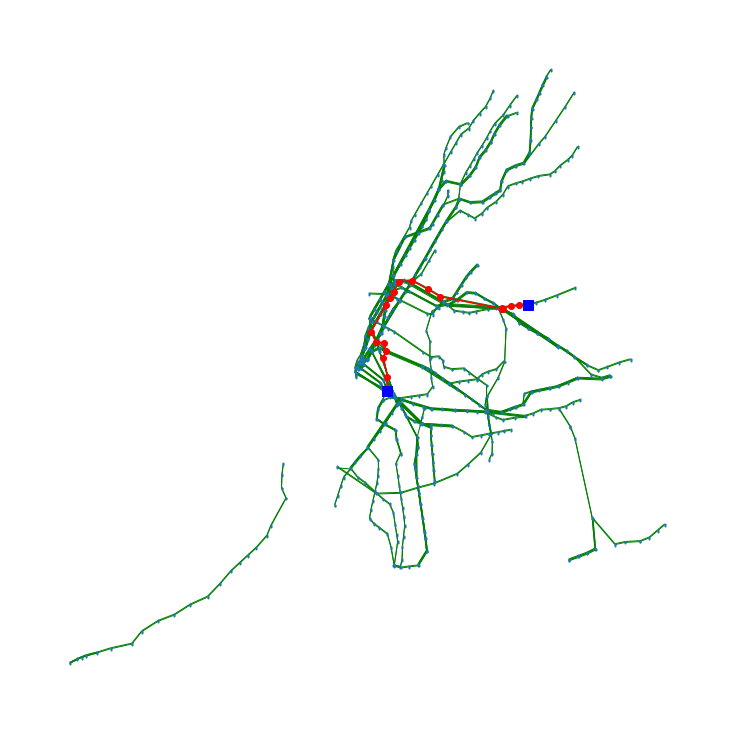

In [35]:
ax1 = visualize_path(path1)
#ax1 = visualize_path(path2)

#### Task 1b. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707) in terms of travel distance 

In [ ]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
#compute and assing lengths the all the edges
nx.set_edge_attributes(uuNYCSubway, 'dist', 0)
for e in uuNYCSubway.edges():
   uuNYCSubway[e[0]][e[1]]['dist']=geodist(nodePos[e[0]][0],nodePos[e[0]][1],nodePos[e[1]][0],nodePos[e[1]][1])

In [ ]:
path1=nx.shortest_path(uuNYCSubway,'A41','707',weight='dist') #shorest path according to dist

In [ ]:
visualize_path(path1)